In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from model import Net, device
from dataset import MyData

samples = torch.load('Kislovodsk.pt')
IMG_SIZE = samples[0].shape
PATH_TO_RESULTS = './Tests/Kislovodsk/'
num_epochs = 3e+4

Selected devie is cuda:0


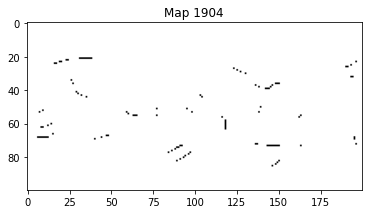

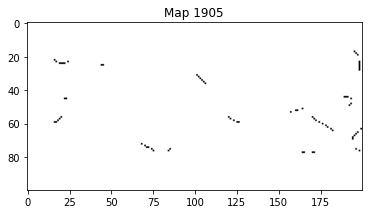

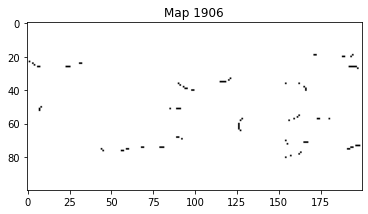

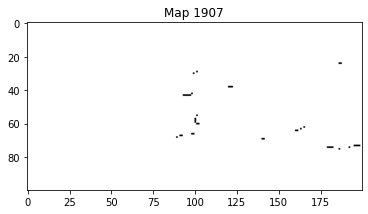

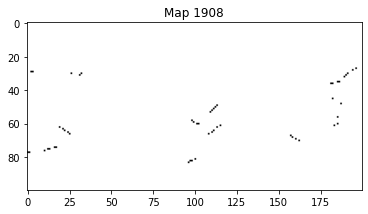

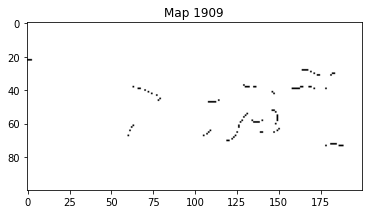

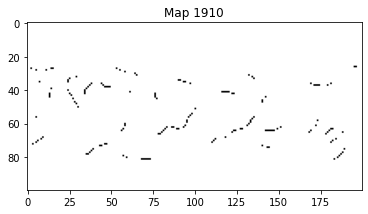

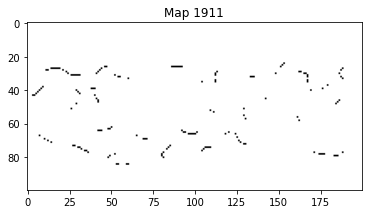

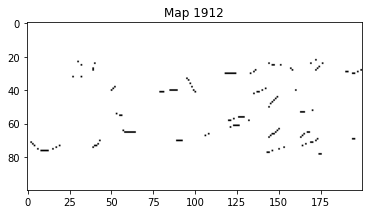

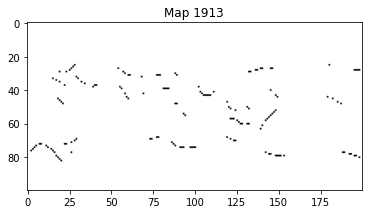

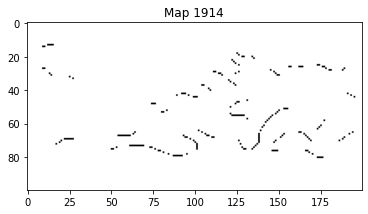

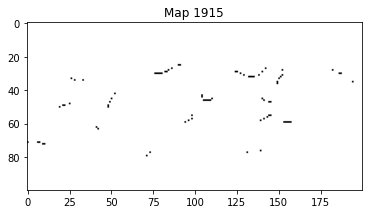

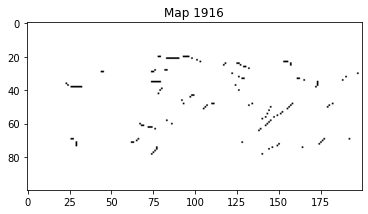

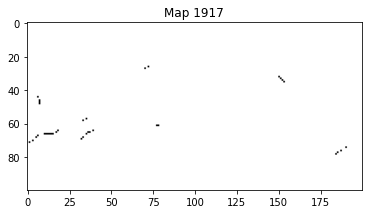

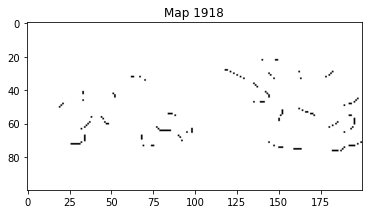

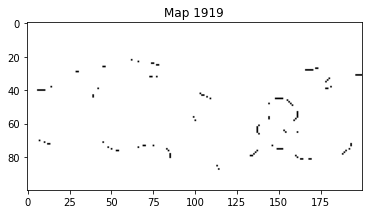

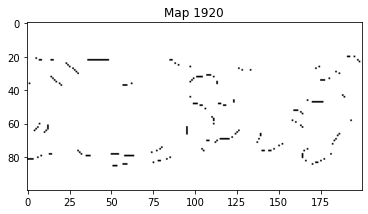

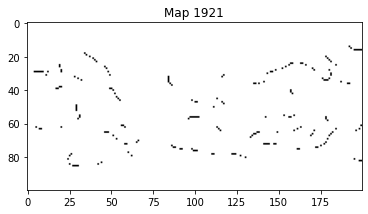

In [21]:
for i, sample in enumerate(samples):
    plt.imshow(sample, cmap='gray')
    # plt.axis('off')
    plt.title(f'Map {1904 + i}')
    plt.show()

In [22]:
os.makedirs(PATH_TO_RESULTS, exist_ok=True)
for i, sample in tqdm(enumerate(samples), desc='Samples', total=len(samples)):
    dataset = MyData(path_or_img=sample, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1)
    dataset_list = [dataset]
    map_num = 1904 + i
    cur_dir = os.path.join(PATH_TO_RESULTS, str(map_num))
    os.mkdir(cur_dir)
    res = []
    for j in range(9):
        model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
        model.to(device)
        model.start_training(num_epochs=num_epochs, my_weight=0.1, need_save=False, need_plot=False)
        predictions = model.test_model(need_plot=False)
        prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.title(f'Filaments on map №{map_num}')
        plt.subplot(1, 2, 2)
        plt.imshow(prediction, cmap='PuOr')
        plt.axis('off')
        plt.title('Model prediction')
        plt.savefig(os.path.join(cur_dir, f'prediction_{j+1}.png'))
        plt.close()
        plt.clf()
        torch.save(model.state_dict(), os.path.join(cur_dir, f'model_{j+1}.pt'))
        res.append(prediction)
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'All runs on map №{map_num}')
    for n, r in enumerate(res):
        plt.subplot(3, 3, n+1)
        plt.imshow(r, cmap='PuOr')
        plt.axis('off')
    plt.savefig(os.path.join(cur_dir, 'predictions_all.png'))
    plt.close()
    plt.clf()

Samples:   0%|          | 0/18 [00:00<?, ?it/s]


FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: './Tests/Kislovodsk/1904'

In [2]:
results = []
for i, sample in enumerate(samples):
    dataset = MyData(path_or_img=sample, data_mode='img', mode_3d='cylinder', radius=1, reduce_fctor=1)
    dataset_list = [dataset]
    map_num = 1904 + i
    cur_dir = os.path.join(PATH_TO_RESULTS, str(map_num))
    res = []
    IMG_SIZE = sample.shape
    for j in range(9):
        model = Net(dataset_list=dataset_list, lr=1e-3, weight_decay=1e-3)
        model.to(device)
        model.load_state_dict(torch.load(os.path.join(cur_dir, f'model_{j+1}.pt')))
        predictions = model.test_model(need_plot=False)
        prediction = predictions[0].view(*IMG_SIZE).cpu().detach()
        res.append((prediction > 0).numpy().astype(np.uint8))    
    results.append(res)
    

In [3]:
results = np.array(results)
results.shape

(18, 9, 100, 200)

In [4]:
lengths = []

for j, res in enumerate(results):
    # plt.figure(figsize=(20, 10))
    avg = 0
    avgs = []
    for i, r in  enumerate(res):
        img = r.copy()
        original = np.zeros_like(img)
        for x in range(1, img.shape[0]-1):
            for y in range(1, img.shape[1]-1):
                original[x, y] = r[x, y] and (not r[x-1, y] or not r[x+1, y] or not r[x, y-1] or not r[x, y+1])
        # plt.subplot(3, 3, i+1)
        # plt.imshow(1-original, cmap='gray')
        l = np.sum(original)
        avg += l
        # plt.title(f'Length of neutral line: {l}')
        # plt.xticks([])
        # plt.yticks([])
        avgs.append(l)
    lengths.append(avgs)
    # plt.suptitle(f'Average length of neutral line: {avg/9:.0f}')

In [5]:
lengths

[[468, 515, 466, 520, 605, 575, 492, 451, 508],
 [383, 402, 374, 383, 361, 362, 386, 344, 402],
 [498, 494, 498, 493, 505, 494, 512, 443, 514],
 [314, 248, 259, 241, 261, 254, 294, 269, 294],
 [355, 368, 361, 340, 405, 368, 367, 304, 377],
 [369, 364, 424, 342, 370, 378, 385, 379, 363],
 [593, 627, 599, 556, 672, 654, 591, 578, 539],
 [565, 437, 632, 462, 543, 541, 498, 542, 594],
 [449, 458, 410, 430, 593, 575, 593, 483, 493],
 [460, 568, 551, 606, 586, 614, 594, 565, 647],
 [508, 526, 560, 662, 532, 551, 528, 598, 547],
 [326, 389, 287, 285, 452, 337, 408, 261, 370],
 [483, 395, 487, 509, 485, 536, 477, 509, 494],
 [296, 273, 282, 295, 271, 276, 269, 262, 300],
 [556, 508, 520, 552, 484, 513, 524, 588, 502],
 [414, 318, 442, 536, 393, 420, 298, 399, 387],
 [609, 524, 520, 540, 649, 720, 621, 549, 594],
 [734, 688, 614, 625, 572, 706, 781, 624, 659]]

In [6]:
# lengts contains arrays with 9 values
# i want to plot mean of each array and std
# and also plot mean of all arrays and std

mean_lengths = np.mean(lengths, axis=1)
std_lengths = np.std(lengths, axis=1)

mean_lengths, std_lengths

(array([511.11111111, 377.44444444, 494.55555556, 270.44444444,
        360.55555556, 374.88888889, 601.        , 534.88888889,
        498.22222222, 576.77777778, 556.88888889, 346.11111111,
        486.11111111, 280.44444444, 527.44444444, 400.77777778,
        591.77777778, 667.        ]),
 array([48.15817559, 18.19713721, 19.65316548, 23.26232582, 25.92772481,
        20.92549983, 40.94983381, 57.96635891, 67.16278364, 49.51941881,
        44.32066096, 60.01193297, 36.50706003, 12.79853387, 30.32091728,
        65.14731644, 62.47448862, 62.32352864]))

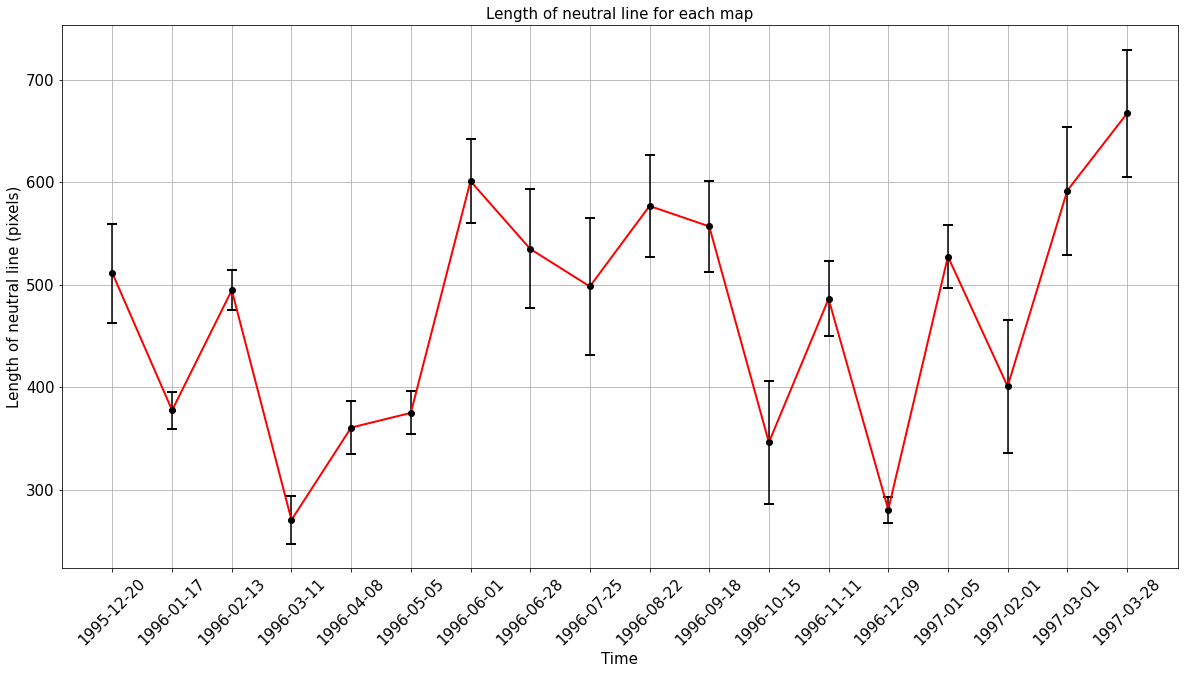

In [29]:
from sunpy.coordinates.sun import carrington_rotation_time
plt.figure(figsize=(20, 10))

# plot mean +- std for each map

for i, (m, s) in enumerate(zip(mean_lengths, std_lengths)):
    map_num = 1904 + i
    plt.errorbar(i, m, yerr=s, fmt='o', color='black', capsize=5, capthick=2, label=f'Map №{1904+i}')
    # connect means
    if i > 0:
        plt.plot([i-1, i], [mean_lengths[i-1], m], color='red', linewidth=2)
    # set xticks as carr time from map number
    plt.xticks(np.arange(len(mean_lengths)), [f'{carrington_rotation_time(i).strftime("%Y-%m-%d")}' for i in range(1904, 1904+len(mean_lengths))], rotation=45)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Length of neutral line (pixels)', fontsize=15)
    plt.title('Length of neutral line for each map', fontsize=15)
    # make grid
    plt.grid(True)
    # make axis values bigger
    plt.tick_params(axis='both', which='major', labelsize=15)

In [17]:
from sunpy.coordinates.sun import carrington_rotation_time
import astropy.units as u
t = carrington_rotation_time(1904)
print(t)

1995-12-20 17:20:46.412
